In [1]:
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import glob
import os 
import cv2
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils

Using TensorFlow backend.


## Given architechture

In [2]:
stae_model=Sequential()
stae_model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
stae_model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
stae_model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

stae_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 26, 26, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 55, 55, 10, 128)   204928    
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 227, 227, 10, 1)  

In [3]:
stae_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [4]:
#dataset loading
training_data=np.load('training.npy')
training_data.shape

(227, 227, 6136)

In [5]:
frames=training_data.shape[2]
frames=frames-frames%10
training_data=training_data[:,:,:frames]

In [6]:
training_data.shape

(227, 227, 6130)

In [7]:
training_data=training_data.reshape(-1,227,227,10)

In [8]:
training_data.shape

(613, 227, 227, 10)

In [9]:
training_data=np.expand_dims(training_data,axis=4)
training_data.shape

(613, 227, 227, 10, 1)

In [10]:
target_data=training_data.copy()
epochs=20
batch_size=1
callback_save = ModelCheckpoint("saved_model.h5", monitor="loss", verbose = 1, save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='loss', patience=3)
history = stae_model.fit(training_data,target_data, batch_size=batch_size, epochs=epochs, callbacks = [callback_save,callback_early_stopping])

Epoch 1/20
613/613 [==============================] - 106s 172ms/step - loss: 0.0686 - accuracy: 0.7375

Epoch 00001: loss improved from inf to 0.06857, saving model to saved_model.h5
Epoch 2/20
613/613 [==============================] - 102s 166ms/step - loss: 0.0296 - accuracy: 0.7796

Epoch 00002: loss improved from 0.06857 to 0.02955, saving model to saved_model.h5
Epoch 3/20
613/613 [==============================] - 102s 167ms/step - loss: 0.0228 - accuracy: 0.7833

Epoch 00003: loss improved from 0.02955 to 0.02275, saving model to saved_model.h5
Epoch 4/20
613/613 [==============================] - 103s 168ms/step - loss: 0.0290 - accuracy: 0.7796

Epoch 00004: loss did not improve from 0.02275
Epoch 5/20
613/613 [==============================] - 104s 169ms/step - loss: 0.0176 - accuracy: 0.7857

Epoch 00005: loss improved from 0.02275 to 0.01757, saving model to saved_model.h5
Epoch 6/20
613/613 [==============================] - 103s 167ms/step - loss: 0.0144 - accuracy: 0.7

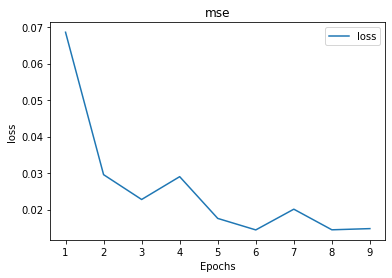

In [11]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="loss")
plt.title("mse")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("loss_graph.jpeg")
plt.show()